In [1]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mlp
import matplotlib.pyplot as plt
import geopandas as gp
import seaborn as sb
import os
import re
import scipy.stats as st
%matplotlib inline
plt.style.use('ggplot')


In [2]:
sb.set_style("whitegrid")
plt.rcParams["ytick.labelsize"] = 13
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["grid.linewidth"] = 2.0
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.1
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.framealpha"]= 0.9
plt.rcParams["legend.edgecolor"] = "black"
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["figure.titlesize"] = 18
plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.autolayout"] = False
pd.options.display.max_columns = 1000

In [4]:
os.chdir("../../../core")
import GT_helper_functions as hf
import GT_load_data as data

base_dir = "../../Outcome Measurement Data/MALARIA/"

In [5]:
# Esto no incluye toda las áreas del país. Sólo las áreas vistas en la base de datos de notifs.
notifs_das2depto = {
    "Escuintla": 5,
    "Alta Verapaz": 16,
    "Izabal" : 18,
    "Suchitepéquez" : 10,
    "Suchitepequez" : 10,
    "Santa Rosa" : 6,
    "Retalhuleu" : 11,
    "Petén Norte" : 17,
    "Peten Norte": 17,
    "Petén SurOccidente" : 17,
    "Petén SurOccidental" : 17,
    "Peten SurOriente" : 17,
    "Huehuetenango" : 13,
    "Quiché" : 14,
    "El Quiché": 14,
    "Petén Sur Oriental" : 17,
    "Baja Verapaz" : 15,
    "Sololá" : 7,
    "Zacapa" : 18,
    "Ixcán" : 14,
    "San Marcos" : 12,
    "Chimaltenango" : 4,
    "Guatemala Central" : 1,
    "Guatemala Sur" : 1,
    "Guatemala Nororiente" : 1,
    "Guatemala Noroccidente" : 1,
    "Ixil" : 14,
    "Jutiapa" : 22,
    "Chiquimula" : 20,
    "Ixcan" : 14,
    "El Progreso" : 2,
    "Guatemala Nororiental" : 1,
    "Quetzaltenango" : 9,
    "Jalapa": 21,
    "LNS": 1
}
code2depto = {
    5: "Escuintla",
    16:"Alta Verapaz",
    18: "Izabal",
    10: "Suchitepéquez",
    6: "Santa Rosa",
    11: "Retalhuleu",
    17: "Petén",
    13: "Huehuetenango",
    14: "Quiché",
    15: "Baja Verapaz",
    7: "Sololá",
    18: "Zacapa",
    12: "San Marcos",
    4: "Chimaltenango",
    1: "Guatemala",
    22: "Jutiapa",
    20: "Chiquimula",
    2: "El Progreso",
    9: "Quetzaltenango",
    3: "Sacatepequez",
    21: "Jalapa"
}

In [6]:
bednets = pd.read_csv(base_dir + "GTM - Bednets Distr.csv", index_col = 0 , low_memory=False)
notifs = pd.read_excel(base_dir + "Base de datos 2016 - 2018 NAD.xlsx")

In [9]:
colvols5_2017 = pd.read_excel(base_dir + "Colaboradores Voluntarios  Escuintla 2017 y 2019.xlsx", 0, skiprows=3, usecols=[1,2,3,4])
colvols5_2019 = pd.read_excel(base_dir + "Colaboradores Voluntarios  Escuintla 2017 y 2019.xlsx", 1, skiprows=2, usecols=[1,2,3,4])


In [11]:
colvols5_2017 = colvols5_2017[colvols5_2017["Nombre del Colaborador Voluntario"].notna()]
colvols5_2019 = colvols5_2019[colvols5_2019["Nombre del Colaborador Voluntario"].notna()]

In [12]:
colvols5_2017.shape, colvols5_2019.shape

((186, 4), (186, 4))

In [13]:
colvols5_2017["Nombre del Distrito de Salud"].value_counts()

Tiquisate            53
La Gomera            42
Santa Lucia Cotz.    40
Masagua              36
Democracia           15
Name: Nombre del Distrito de Salud, dtype: int64

In [15]:
escuintlaDtoCode = {
    "Tiquisate": "506",
    "La Gomera": "507",
    "Santa Lucia Cotz.":  "502",
    "Masagua":  "505",
    "Democracia":  "503"
}

In [113]:
mlp.rcParams['figure.figsize'] = [8, 8]

_i_ = lambda x: x

def mapGT(data_, chlor_col, scatter_col = None, labelChlor = None, labelScatter = None, ax_ = None, normalizeScatterSize = _i_):
    temp = data.deptosGTshp.merge(data_, 
                         left_on="deptocode", right_on = "deptocode", how="left" )
    if ax_ is None:
        ax = plt.axes()
    else:
        ax = ax_
    temp[temp[chlor_col].isna() | (temp[chlor_col]==0) | (np.isinf(temp[chlor_col]))].plot(color="#999999", ax= ax) 

    temp[(temp[chlor_col].isna()==False) & (temp[chlor_col]> -np.Inf)].plot(chlor_col, vmin = 0, vmax = temp[chlor_col].max(),
                                    legend=False, linewidth=0, cmap = "Blues", ax = ax)
    l1 = ax.get_legend()
    for i, depto in data.deptosGTshp.iterrows():
        plt.text(depto.geometry.centroid.x, (depto.geometry.bounds[3]+1.5*depto.geometry.centroid.y)/2.5, 
                 hf.abbreviate(depto.DEPARTAMEN), color="black",
                 horizontalalignment='center', alpha=0.8, fontsize=9)
    if scatter_col is not None:
        temp2 = data.deptosGTshp.merge(data_, 
                             left_on="deptocode", right_on = "deptocode", how="left" )\
            .assign(x = lambda row: row.geometry.centroid.x)\
            .assign(y = lambda row: row.geometry.centroid.y)
        temp2 = temp2[temp2["values"]>0]
        plt.scatter(temp2.x, temp2.y, normalizeScatterSize(temp2["values"]), c = "red", alpha=0.6, linewidths=1.5, edgecolors="black", 
                    label = labelScatter)
        plt.legend(bbox_to_anchor=(1,0))
    
    cmap = plt.get_cmap('Blues')
    vmax = temp[chlor_col].max()
    norm = mlp.colors.Normalize(vmin=0,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, shrink = 0.5, ticks=np.linspace(0,vmax,10))
    cbar.set_ticklabels([int(np.round(10**x)) for x in np.linspace(0,vmax,10)])
    cbar.set_label(labelChlor)
    
    data.munisGTshp[(data.munisGTshp.COD_MUNI__.isin([0, None]) == False) & 
                    (data.munisGTshp.COD_DEPT__.isin([0, None]) == False)].plot(edgecolor="#33333355", color="#00000000", linewidth=0.25, ax=ax)
    data.deptosGTshp.plot(edgecolor="#00000055", linewidth=1.5, color="#55555500", ax=ax)

    plt.axis("off")
    plt.tight_layout()


In [37]:
model_3d_b = pd.DataFrame([
    {  "deptocode": 5, "cumbn_effect": -0.168  },
    {  "deptocode": 7, "cumbn_effect": -2.743  },
    {  "deptocode": 13, "cumbn_effect": -0.907  },
    {  "deptocode": 16, "cumbn_effect": -0.254  },
    {  "deptocode": 18, "cumbn_effect": -0.250  }
])
model_3d_b["effect"] = 1 - np.exp(model_3d_b.cumbn_effect)
model_3d_b

,cumbn_effect,deptocode,effect
0,-0.168,5,0.154646
1,-2.743,7,0.935623
2,-0.907,13,0.596266
3,-0.254,16,0.224308
4,-0.250,18,0.221199


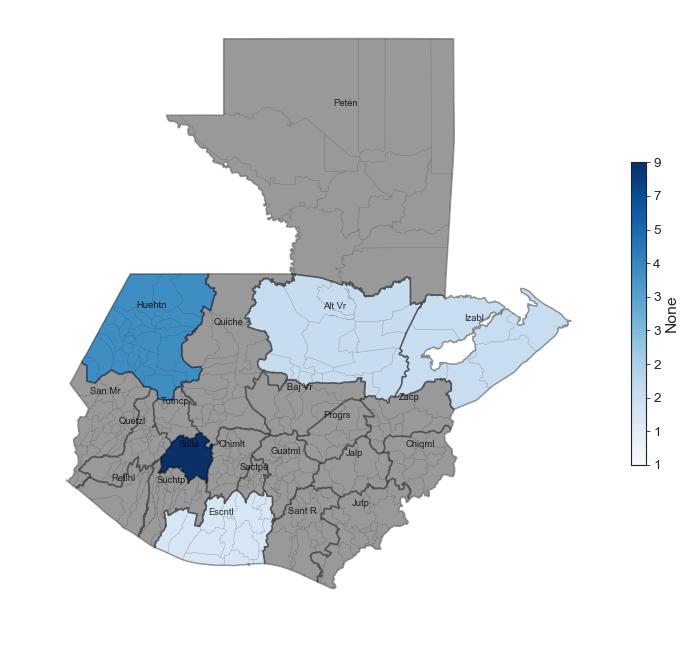

0

In [114]:
mlp.rcParams["figure.figsize"] = (10,8.7)
mlp.rcParams["figure.dpi"] = 75
mapGT(model_3d_b, "effect")
plt.title("")
plt.show()
0